In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

In [2]:
!pip install "https://github.com/megagonlabs/ginza/releases/download/latest/ginza-latest.tar.gz"

# Colabの仕様でpkg_resourcesに新しくインストールしたライブラリが反映されないため，
# 以下のコードで反映させる
import pkg_resources, imp
imp.reload(pkg_resources)

     |████████████████████████████████| 10.4MB 40.2MB/s 
     |████████████████████████████████| 54.6MB 53kB/s 
     |████████████████████████████████| 81kB 13.7MB/s 
     |████████████████████████████████| 70.7MB 42kB/s 
     |████████████████████████████████| 122kB 55.5MB/s 
     |████████████████████████████████| 2.2MB 58.4MB/s 
     |████████████████████████████████| 3.7MB 54.4MB/s 
  Created wheel for ginza: filename=ginza-2.2.1-cp36-none-any.whl size=11781 sha256=060b420de003b659ca21a988358e832dee523bfe27533d8ffc70f839d7f7ca22
  Stored in directory: /root/.cache/pip/wheels/6f/97/43/f9c8c315bcd598f595e96aae207b120a3b84564f03ddd8d6a7
  Created wheel for ja-ginza: filename=ja_ginza-2.2.0-cp36-none-any.whl size=54672047 sha256=a83f5e13df6cfb3f31d182f1d478c3a9e7d4085da6d8862c909bf75f05f70018
  Stored in directory: /root/.cache/pip/wheels/21/63/1e/21ca7586a7abd427e0980f39a66549ba5d2543528b97253952
  Created wheel for SudachiDict-core: filename=SudachiDict_core-20190927-cp36-none-any.wh

<module 'pkg_resources' from '/usr/local/lib/python3.6/dist-packages/pkg_resources/__init__.py'>

In [3]:
import spacy
import pandas as pd
import numpy as np
import random
import sys
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import LambdaCallback

from util import remove_fullspace_and_newline, reweight_distribution, sample

In [4]:
# 歌詞データの読み込み
df = pd.read_csv('./datasets/all_songs.csv')
lyrics = df['Lyric']
lyrics.head()

0    まるで荒れる波涛のように背筋つらぬき　心狂わす出逢いそう　出逢い夢うつつと見紛(みまご)うほ...
1    Don't Don't Don't Stay Good-byeDon't Don't Don...
2    YES♪広い空のようなみんな夢を見てるそして叶えてく輝くこの宇宙(そら)でどこ行(ゆ)こうM...
3    いっしょに歌おういっしょの時代(とき)の中いっしょで行こういっしょな夢を見よういっしょにいよ...
4    アッ！とね　言わせて見たいいっぱい愛があふれるウットリするような世界創ろうガッカリするのまだ...
Name: Lyric, dtype: object

## 前処理

In [5]:
# 前処理(全角スペースや改行を除去)
removed_list = [remove_fullspace_and_newline(lyric) for lyric in lyrics]
removed_list[-2]

'瑠璃色金魚は恋い焦がれる凛と咲き誇る花菖蒲吐き出す空気は泡の模様決してあなたの心に届かないのはなびらひらひらと水面に落ちて震える指先時間が止まるわ目が覚めた余韻の余白外の世界はねえなんて眩しい嘘だとしても罪深過ぎたの眩暈がしても心地いいのはもう求めてるから瑠璃色金魚が見上げるのは凛と佇んだ花菖蒲私あなたのようになれたらもっと上手く微笑えますか灯した明かりは燃えないまま今も青く棚引いている曇った硝子を溶かすほどの秘密もしかして私持ってますか雨は空に落ち愛すれば消えるものと思ってた鏡の世界に逆さまに映った好奇心湧き上がる思いを掬い上げては砂糖漬けにしてまた飲み込むのあなたにいつか味見してほしいと夢を見ながら瑠璃色金魚が知らないのは強く根を張った花菖蒲目の前に見えるもの全てが現実ってことはないのあの時触れてくれた温もり光失くしては枯れていく悲しみで泣く私の涙また毒になってしまう抜け出したい瑠璃色金魚が見上げるのは凛と佇んだ花菖蒲私あなたのようになれたらもっと美しく咲き誇れますか瑠璃色金魚が知らないのは強く根を張った花菖蒲目の前に見えるもの全てが現実ってことはないのあの時触れてくれた温もり光失くしては枯れていく悲しみで泣く私の涙また毒になってしまう抜け出したい私きっと'

In [0]:
# 辞書の準備
# 大量の文書を扱うときはpipeを使うと内部的にバッチ化され，効率化される
nlp = spacy.load('ja_ginza')
docs = list(nlp.pipe(removed_list))

In [7]:
# コーパスの分かち書きの作成
lyrics_wakati = []
for doc in docs:
    lyric_wakati = []
    for word in doc:
        lyric_wakati.append(word.text)  # 各要素はspacy.tokens.token.Tokenなので，textでstrとして抽出
    lyrics_wakati.append(lyric_wakati)
print(lyrics_wakati[-2], sep='\n')      # 整形して瑠璃色金魚と花菖蒲の結果を確認

['瑠璃', '色金', '魚', 'は', '恋い焦がれる', '凛と', '咲き誇る', '花菖蒲', '吐き出す', '空気', 'は', '泡', 'の', '模様', '決して', 'あなた', 'の', '心', 'に', '届か', 'ない', 'の', 'はなびら', 'ひらひら', 'と', '水面', 'に', '落ち', 'て', '震える', '指先', '時間', 'が', '止まる', 'わ', '目', 'が', '覚め', 'た', '余韻', 'の', '余白', '外', 'の', '世界', 'は', 'ねえ', 'なんて', '眩しい', '嘘', 'だ', 'と', 'し', 'て', 'も', '罪深', '過ぎ', 'た', 'の', '眩暈', 'が', 'し', 'て', 'も', '心地', 'いい', 'の', 'は', 'もう', '求め', 'てる', 'から', '瑠璃', '色金', '魚', 'が', '見上げる', 'の', 'は', '凛と', '佇ん', 'だ', '花菖蒲', '私', 'あなた', 'の', 'よう', 'に', 'なれ', 'たら', 'もっと', '上手く', '微笑え', 'ます', 'か', '灯し', 'た', '明かり', 'は', '燃え', 'ない', 'まま', '今', 'も', '青く', '棚引い', 'て', 'いる', '曇っ', 'た', '硝子', 'を', '溶かす', 'ほど', 'の', '秘密', 'もし', 'か', 'し', 'て', '私', '持っ', 'て', 'ます', 'か', '雨', 'は', '空', 'に', '落ち', '愛すれ', 'ば', '消える', 'もの', 'と', '思っ', 'て', 'た', '鏡', 'の', '世界', 'に', '逆さま', 'に', '映っ', 'た', '好奇心', '湧き上がる', '思い', 'を', '掬い上げ', 'て', 'は', '砂糖', '漬け', 'に', 'し', 'て', 'また', '飲み込む', 'の', 'あなた', 'に', 'いつ', 'か', '味見', 'し', 'て', 'ほしい', 'と', '夢', 'を', '見', 'ながら'

In [8]:
# 分かち書きからコーパスの一意な単語のリストを作成
flatten = sum(lyrics_wakati, [])   # 平坦化
print('Corpus length:', len(flatten))

words = sorted(list(set(flatten))) # set(集合)を用いて要素を一意に
print('Unique words:', len(words))

# 歌詞中の単語をリストwordsのインデックスにマッピングするディクショナリ
word_indices = dict((c, i) for i, c in enumerate(words))
indices_word = dict((i, c) for i, c in enumerate(words))

Corpus length: 119916
Unique words: 11362


## 入力と出力(目的値)の作成

In [18]:
maxlen = 5        # 5単語分の歌詞を抽出
step = 3          # 3単語ごとに新しい歌詞をサンプリング
sentences = []    # 抽出された歌詞
next_words = []   # 目的値(次にくる単語)

for i in range(0, len(flatten) - maxlen, step):
    sentences.append(flatten[i: i + maxlen])
    next_words.append(flatten[i + maxlen])

print('Number of sequences:', len(sentences))

Number of sequences: 39971


In [19]:
# ベクトル化(one-hotエンコーディングを適用して文字を二値の配列に格納)
print('Vectorization...')

x = np.zeros((len(sentences), maxlen, len(words)), dtype=np.bool)
y = np.zeros((len(sentences), len(words)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, word in enumerate(sentence):
        x[i, t, word_indices[word]] = 1
    y[i, word_indices[next_words[i]]] = 1
    
print('shape of x:', x.shape)
print('shape of y:', y.shape)

Vectorization...
shape of x: (39971, 5, 11362)
shape of y: (39971, 11362)


## モデルの構築

In [24]:
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(maxlen, len(words))))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(len(words), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop')

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 5, 256)            11766784  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_6 (Dense)              (None, 11362)             1465698   
Total params: 13,396,834
Trainable params: 13,396,834
Non-trainable params: 0
_________________________________________________________________


In [0]:
# コールバックの設定
def print_temp_res(epoch, _):
    if (epoch + 1) % 10 == 0 or epoch == 0:
        
        print()
        print('----- Generating lyrics after Epoch: {}'.format(epoch))
        
        # テキストシードをランダムに選択
        start_index = random.randint(0, len(flatten) - maxlen - 1)
        
        # ある範囲内の異なるサンプリング温度を試す
        for temperature in [0.2, 0.5, 1.0, 1.2]:
            print('----- temperature:', temperature)
            
            generated_lyric = ''
            sentence = flatten[start_index: start_index + maxlen]
            generated_lyric += ''.join(sentence)  # リストなので1つのstrにまとめる
            print('----- Generating with seed: "' + generated_lyric + '"')
            sys.stdout.write(generated_lyric)
            
            # 400文字生成
            for i in range(400):
                # これまでに生成された単語にone-hotエンコーディングを適用
                sampled = np.zeros((1, maxlen, len(words)))
                for t, word in enumerate(sentence):
                    sampled[0, t, word_indices[word]] = 1.
                    
                # 次の単語をサンプリング
                preds = model.predict(sampled, verbose=0)[0]
                next_index = sample(preds, temperature)
                next_word = indices_word[next_index]
                
                generated_lyric += next_word
                generated_lyric = generated_lyric[1:]
                
                sys.stdout.write(next_word)
                sys.stdout.write(' ')
                sys.stdout.flush()
            print()
    else:
        pass

## 学習

In [26]:
callback = LambdaCallback(on_epoch_end=print_temp_res)
history = model.fit(x, y,
                    batch_size=128,
                    epochs=200,
                    callbacks=[callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 39971 samples
Epoch 1/200
39936/39971 [============================>.] - ETA: 0s - loss: 7.0130
----- Generating lyrics after Epoch: 0
----- temperature: 0.2
----- Generating with seed: "歩く道せせらぎの音"
歩く道せせらぎの音に に の に で に て に に の に も に に て に に の て て の の の に を に の を ！ の の に ！ て の て に て に て に の て ！ ！ に て に て に て ！ た て て に ！ に の て に の の ！ て に の は が の に て に も で に て の に で て て の て の に に の の て に の に に に に ！ ！ の に の て ！ に に ！ に て の の に ！ て ！ て て に て も ！ の に で ！ て も ！ て て に て ！ に の の て て ！ て に に の に て ！ に て の の の て て に に て の て に に に に は に に に に に に に に に て て に に を の に に の の で て の に の の て の ！ て に ない に の の に て の て の に の の に ない の に に が に ！ に ！ に て て に の て て の て に て て の の に て の の に ！ の に の て に に に に に て に の に て だ に に の て ！ の て に の に て に て の の の の の に ！ の の て に の て ！ の に て に に て に ！ て て ！ に に の の に は に ！ の に に に ！ に て に ！ に て て に に に ！ に に ない て て に て て に を の て に の の に の の ！ ！ に は て が た て に に に ！ ！ て の

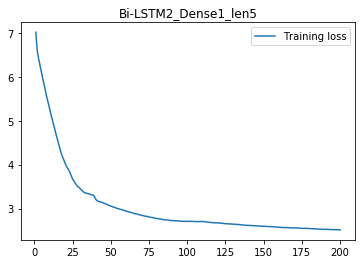

In [27]:
import matplotlib.pyplot as plt

# 損失をプロット
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.title('Bi-LSTM2_Dense1_len5')
plt.legend()
plt.savefig('Bi-LSTM2_Dense1_len5.png')
plt.show()

In [0]:
# モデルの保存
model.save('Bi-LSTM2_Dense1_len5.h5')